# Seasonal Cycle Plotting

## Environment Settings

In [72]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster() 
cluster.adapt(minimum = 2, maximum = 8, interval='2s')

client = Client(cluster) 
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.2.208:38137
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-9d12ea58-520b-11ea-8176-d66c6040a763
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.2.208:38137 Dashboard: /user/0000-0001-5234-177x/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [1]:
!pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git

  Cloning https://github.com/JiaweiZhuang/xESMF.git to /tmp/pip-req-build-_mp9jw_i
  Running command git clone -q https://github.com/JiaweiZhuang/xESMF.git /tmp/pip-req-build-_mp9jw_i
  Created wheel for xesmf: filename=xesmf-0.2.1-py3-none-any.whl size=18886 sha256=7e2224defa4534113be8d118892a6c9512bb8bfda8dc7c71709ff09bee0346a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-dn5rwfpi/wheels/d7/d9/36/77fa4453320fcc02ae0c467f668d1583e9fcbea536c2aaf287
Successfully built xesmf
  Attempting uninstall: xesmf
    Found existing installation: xesmf 0.2.1
    Uninstalling xesmf-0.2.1:
      Successfully uninstalled xesmf-0.2.1


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import os.path
import xesmf as xe
from scipy.signal import detrend

In [4]:
%matplotlib inline
Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');
# plt.rcParams['figure.figsize'] = 12, 6
# %config InlineBackend.figure_format = 'retina'  #enabling 2x PNG matplotlib plots in the IPython notebook
Colors = [[1, 1, 0], [1, 0.8, 0], [1, 0.6, 0], 
          [1, 0.4, 0], [1, 0, 0], [1, 0.8, 1],
          [1, 0.5, 1], [1, 0, 1], [0, 0, 0.5],
          [0, 0, 1], [0, 0.5, 1], [0, 0.5, 0], 
          [0, 1, 0], [0, 0.6, 0], [0.5, 0.2, 0]]   


## Data Access

In [5]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
        print(model, var, "found data")
    except:
        ds = []
        #print(model, var, "no data")
    return ds        

In [75]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
          'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
          'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
expe = 'historical'
freq = 'Omon'
start_year = '1991'
end_year = '2010'

In [50]:
# test
t_var = 'phydiat'
t_model = 'CESM2'
t_ds = get_data(df, t_var, t_model, expe, freq)
t_ds[t_var]

CESM2 phydiat found data


<xarray.DataArray 'phydiat' (time: 1980, lev: 15, nlat: 384, nlon: 320)>
dask.array<zarr, shape=(1980, 15, 384, 320), dtype=float32, chunksize=(12, 15, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev      (lev) float64 500.0 1.5e+03 2.5e+03 ... 1.25e+04 1.35e+04 1.45e+04
    lon      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat     (nlat) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * time     (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        carbon from the diatom phytoplankton component concentrat...
    description:    carbon from the diatom phytoplankton component concentrat...
    frequency:      mon
    id:             phydiat
    long_name:      Mole Concentration of Diatoms Expressed as Carbon in Sea ...
    mipTable:       Omon
    out_name:       phydiat
    prov:           Omon ((isd.003))
    realm:          ocnBgchem
    standard_name:  mole_concentration_of_diatoms_expressed_as_carbon_in_sea_...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Mole Concentration of Diatoms Expressed as Carbon in Sea ...
    type:           real
    units:          mol m-3
    variable_id:    phydiat

## Data Pre-processing
    1. Regridding

In [52]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0))})

In [ ]:
%%time

regrids = []
for model in models:
    if isinstance(xray_dic[model], xr.Dataset):
        ds = xray_dic[model].sel(time=slice(start_year, end_year))[var]
        
        if 'latitude' in ds.coords:
            ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in ds.coords:
            ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
                
        dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        dsr._grid_in = None
        dsr._grid_out = None
        dsr_out0 = dsr(ds)
        dsr_out = xr.Dataset({var:dsr_out0})
        dsr.clean_weight_file()
        
    else:
        dsr_out = []
        
    regrids.append(dsr_out)
    
regrid_dic = {key:value for key, value in zip(models, regrids)}

In [ ]:
for model in models:
    if isinstance(regrid_dic[model], xr.Dataset):
        ds = regrid_dic[model]
        print(ds)

    2. PAPA & NAPA

In [97]:
%%time

papa_aray = []
for model in models:
    ds = regrid_dic[model]
    
    if isinstance(ds, xr.Dataset):
        if 'lev_partial' in ds.coords:
            ds = ds.isel(lev_partial=0)
        if 'olevel' in ds.coords:
            ds = ds.isel(olevel=0)
        if 'lev' in ds.coords:
            ds = ds.isel(lev=0)
        
        if ds[var].shape[0]==240:
            ds_r = ds.sel(lat=slice(45,50)).sel(lon=slice(220,230))
            dsm = ds_r[var].mean(dim='time')
            ds_anom = ds_r[var] - dsm
            ds_anom.load()
            ds_anom_detrended = xr.apply_ufunc(detrend, ds_anom, kwargs={'axis': 0}).where(~ds_anom.isnull())
            ds_detrend = ds_anom_detrended + dsm
            ds = ds_detrend.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
        else:
            ds = []
            print(model, regrid_dic[model])
        
    papa_aray.append(ds)

papa_dic = {key:value for key, value in zip(models, papa_aray)}

distributed.scheduler - INFO - Remove worker tcp://10.32.6.17:42853
distributed.core - INFO - Removing comms to tcp://10.32.6.17:42853


CPU times: user 6.96 s, sys: 4.84 s, total: 11.8 s
Wall time: 50.8 s


distributed.scheduler - INFO - Remove worker tcp://10.32.4.3:40617
distributed.core - INFO - Removing comms to tcp://10.32.4.3:40617
distributed.scheduler - INFO - Remove worker tcp://10.32.4.2:38255
distributed.core - INFO - Removing comms to tcp://10.32.4.2:38255
distributed.scheduler - INFO - Lost all workers


3. loop for all models, variable

In [128]:
var_names=['phyc','chl','phydiat','zooc','intpp','epc100',
           'fgco2','spco2','dfe','no3','si','rsntds']

In [ ]:
%%time

data_np = {}
data_na = {}
for model in models:
    datav_np = {}
    datav_na = {}
    for var in var_names:
        
        xray = get_data(df, var, model, expe, freq)
        
        if isinstance(xray, xr.Dataset):
            
            ds = xray.sel(time=slice(start_year, end_year))[var]
            
            if 'latitude' in ds.coords:
                ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
            if 'nav_lat' in ds.coords:
                ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
            if 'lev_partial' in ds.coords:
                ds = ds.isel(lev_partial=0)
            if 'olevel' in ds.coords:
                ds = ds.isel(olevel=0)
            if 'lev' in ds.coords:
                ds = ds.isel(lev=0)
                
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                    ds = ds.where(ds>=0)                
                
            dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
            dsr._grid_in = None
            dsr._grid_out = None
            dsr_out0 = dsr(ds)
            dsr_out = xr.Dataset({var:dsr_out0})
            
            
            if 'lev_partial' in dsr_out.coords:
                dsr_out = dsr_out.isel(lev_partial=0)
            if 'olevel' in dsr_out.coords:
                dsr_out = dsr_out.isel(olevel=0)
            if 'lev' in dsr_out.coords:
                dsr_out = dsr_out.isel(lev=0)
                
            if dsr_out[var].shape[0]==240:
                ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220))
                dsm_np = ds_np[var].mean(dim='time',skipna=1)
                anom_np = ds_np[var] - dsm_np
                anom_np.load()
                anom_detrended_np = xr.apply_ufunc(detrend, anom_np, kwargs={'axis': 0}).where(~anom_np.isnull())
                detrend_np = anom_detrended_np + dsm_np
                do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                
                datav_np[var] = do_np
                savef_np = 'save/' + model + '_' + var + '_np.txt'
                with open(savef_np, 'w') as npf:
                    for idata in do_np:
                        npf.write(str(idata) +"\n")
                
                ds_na = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(325,335))
                dsm_na = ds_na[var].mean(dim='time',skipna=1)
                anom_na = ds_na[var] - dsm_na
                anom_na.load()
                anom_detrended_na = xr.apply_ufunc(detrend, anom_na, kwargs={'axis': 0}).where(~anom_na.isnull())
                detrend_na = anom_detrended_na + dsm_na
                do_na = detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                
                datav_na[var] = do_na
                savef_na = 'save/' + model + '_' + var + '_na.txt'
                with open(savef_na, 'w') as naf:
                    for idata in do_na:
                        naf.write(str(idata) +"\n")
                        
            dsr.clean_weight_file()
    
    data_np[model] = datav_np
    data_na[model] = datav_na

In [16]:
%%time

#new_models = ['GISS-E2-1-G', 'GISS-E2-1-G-CC']
new_vars = ['fgco2']

for model in models:
    for var in new_vars:
        xray = get_data(df, var, model, expe, freq)
        
        if isinstance(xray, xr.Dataset):
            
            ds = xray.sel(time=slice(start_year, end_year))[var]
            
            if 'latitude' in ds.coords:
                ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
            if 'nav_lat' in ds.coords:
                ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
            if 'lev_partial' in ds.coords:
                ds = ds.isel(lev_partial=0)
            if 'olevel' in ds.coords:
                ds = ds.isel(olevel=0)
            if 'lev' in ds.coords:
                ds = ds.isel(lev=0)
                
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                    ds = ds.where(ds>=0)
                
            dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
            dsr._grid_in = None
            dsr._grid_out = None
            dsr_out0 = dsr(ds)
            dsr_out = xr.Dataset({var:dsr_out0})
            
                
            if dsr_out[var].shape[0]==240:
                ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220))
                dsm_np = ds_np[var].mean(dim='time',skipna=1)
                anom_np = ds_np[var] - dsm_np
                anom_np.load()
                anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0), kwargs={'axis': 0}).where(~anom_np.isnull())
                detrend_np = anom_detrended_np + dsm_np
                do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                if var == 'spco2':
                    do_np = do_np / 0.101325
                if var == 'fgco2':
                    do_np = do_np * 3600 * 24 * 365 * 1000 / (44/12) 
                
                savef_np = 'save/' + model + '_' + var + '_np.txt'
                with open(savef_np, 'w') as npf:
                    for idata in do_np:
                        npf.write(str(idata) +"\n")
                
                ds_na = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(325,335))
                dsm_na = ds_na[var].mean(dim='time', skipna=1)
                anom_na = ds_na[var] - dsm_na
                anom_na.load()
                anom_detrended_na = xr.apply_ufunc(detrend, anom_na.fillna(0), kwargs={'axis': 0}).where(~anom_na.isnull())
                detrend_na = anom_detrended_na + dsm_na
                do_na = detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                if var == 'spco2':
                    do_na = do_na / 0.101325
                if var == 'fgco2':
                    do_na = do_na * 3600 * 24 * 365 * 1000 / (44/12) 
                
                savef_na = 'save/' + model + '_' + var + '_na.txt'
                with open(savef_na, 'w') as naf:
                    for idata in do_na:
                        naf.write(str(idata) +"\n")
                        
            dsr.clean_weight_file()

CanESM5 fgco2 found data
Create weight file: bilinear_291x360_181x361_peri.nc
Remove file bilinear_291x360_181x361_peri.nc
CESM2 fgco2 found data
Create weight file: bilinear_384x320_181x361_peri.nc
Remove file bilinear_384x320_181x361_peri.nc
CESM2-WACCM fgco2 found data
Create weight file: bilinear_180x360_181x361_peri.nc
Remove file bilinear_180x360_181x361_peri.nc
CNRM-ESM2-1 fgco2 found data
Create weight file: bilinear_294x362_181x361_peri.nc
Remove file bilinear_294x362_181x361_peri.nc
GFDL-CM4 fgco2 found data
Create weight file: bilinear_180x360_181x361_peri.nc
Remove file bilinear_180x360_181x361_peri.nc
GISS-E2-1-G fgco2 found data
Create weight file: bilinear_180x288_181x361_peri.nc
Remove file bilinear_180x288_181x361_peri.nc
GISS-E2-1-G-CC fgco2 found data
Create weight file: bilinear_180x288_181x361_peri.nc
Remove file bilinear_180x288_181x361_peri.nc
IPSL-CM6A-LR fgco2 found data
Create weight file: bilinear_332x362_181x361_peri.nc
Remove file bilinear_332x362_181x361_p

## Plotting

In [127]:
plot_titles=['Biomass (mol/m3)','Chlorophyll (kg/m3)','Diatom (mol/m3)', 
             'Zooplankton (mol/m3)','Primary Production (mol/m2/s)','Export Production at 100m (mol/m2/s)',
             'Air-sea CO2 flux (donward +) (gram C /m2/year)','SpCO2 (ppm)', 'Iron - Fe (mol/m3)', 
             'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light - Surface Downward SW Radiation (W/m2)']

CPU times: user 1.25 s, sys: 45 ms, total: 1.29 s
Wall time: 1.27 s


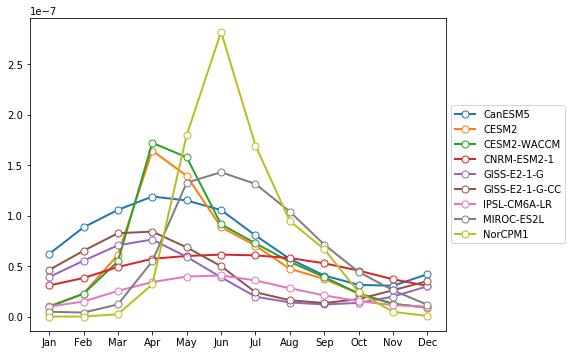

distributed.scheduler - INFO - Register tcp://10.32.4.2:43031
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.2:43031
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.4.4:36019
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.4:36019
distributed.core - INFO - Starting established connection


In [99]:
%%time

plt.figure(figsize=(8.5, 5))
l = []
for model in models:  
    if isinstance(papa_dic[model], list):
        continue
    else:
        s = papa_dic[model]
        if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
            if var == 'chl':
                s = papa_dic[model] * 0.001        # need more infromation
        if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
            if var == 'intpp':
                s = -papa_dic[model]               # need more infromation
            if var == 'fgco2':
                s = papa_dic[model]*(10**(-10))    # need more infromation
        
        plt.plot(np.arange(1, 13), s, label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        l.append(str(model))
        
plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
plt.xticks(np.arange(1, 13), Time_months)
plt.legend(l,loc='center left', bbox_to_anchor=(1, 0.5))
savename = var + '_papa.png'
plt.savefig(savename, dpi=600)    

**Notice** : 'CNRM-ESM2-1', 'IPSL-CM6A-LR':'chl'; 'GISS-E2-1-G', 'GISS-E2-1-G-CC': 'intpp', 'fgco2', 'dfe'

CPU times: user 6.7 s, sys: 177 ms, total: 6.87 s
Wall time: 6.72 s


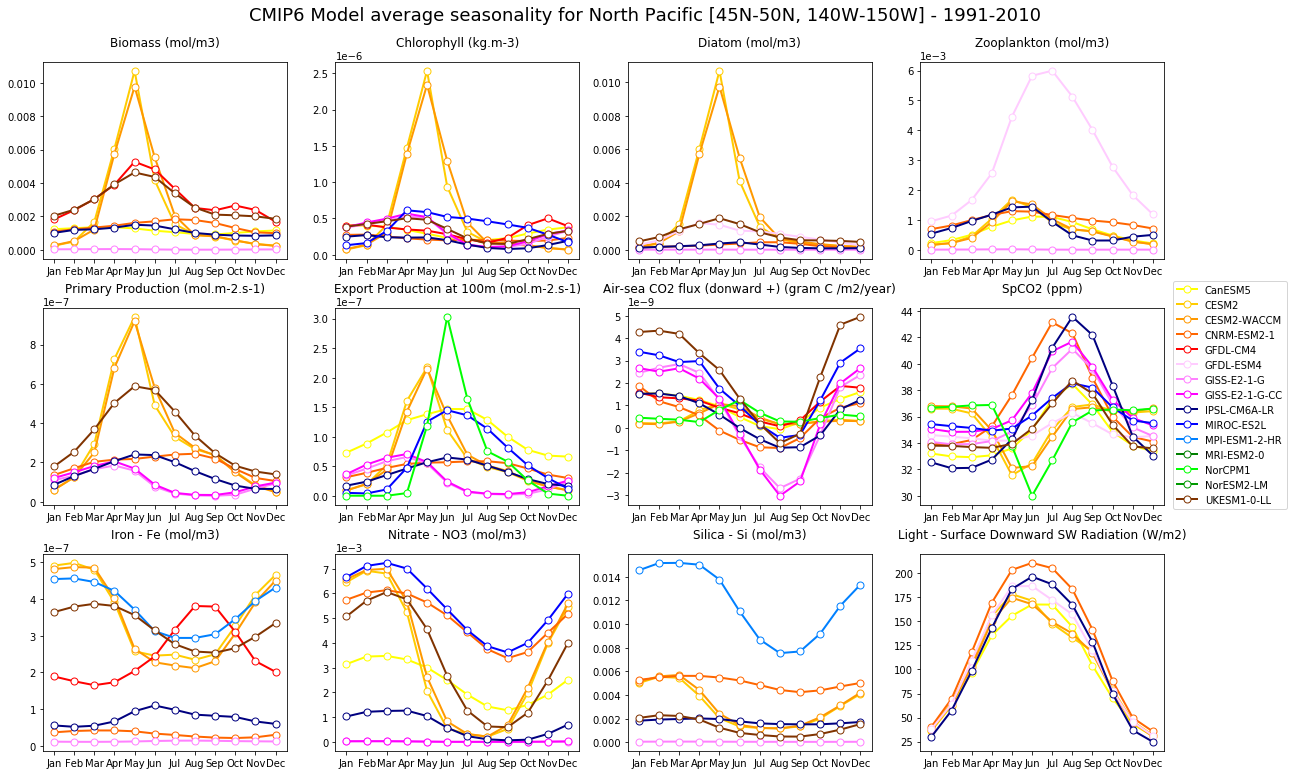

In [12]:
%%time

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 1
for var in var_names:
    
    ax = plt.subplot(ncol,nrow,i)
    i = i + 1
    
    mi = 0
    for model in data_np:
        dm = data_np[model]
        if var in dm:
            s = dm[var]
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = dm[var] * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -dm[var]               # need more infromation
                if var == 'fgco2':
                    s = dm[var]*(10**(-10))    # need more infromation
                if var == 'dfe':
                    s = dm[var] * 0.001        # need more infromation
                    
            plt.plot(np.arange(1, 13), s, c=Colors[mi], label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-2], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('MultiVar_NP_new.png', dpi=600)    


CPU times: user 6.74 s, sys: 157 ms, total: 6.9 s
Wall time: 6.79 s


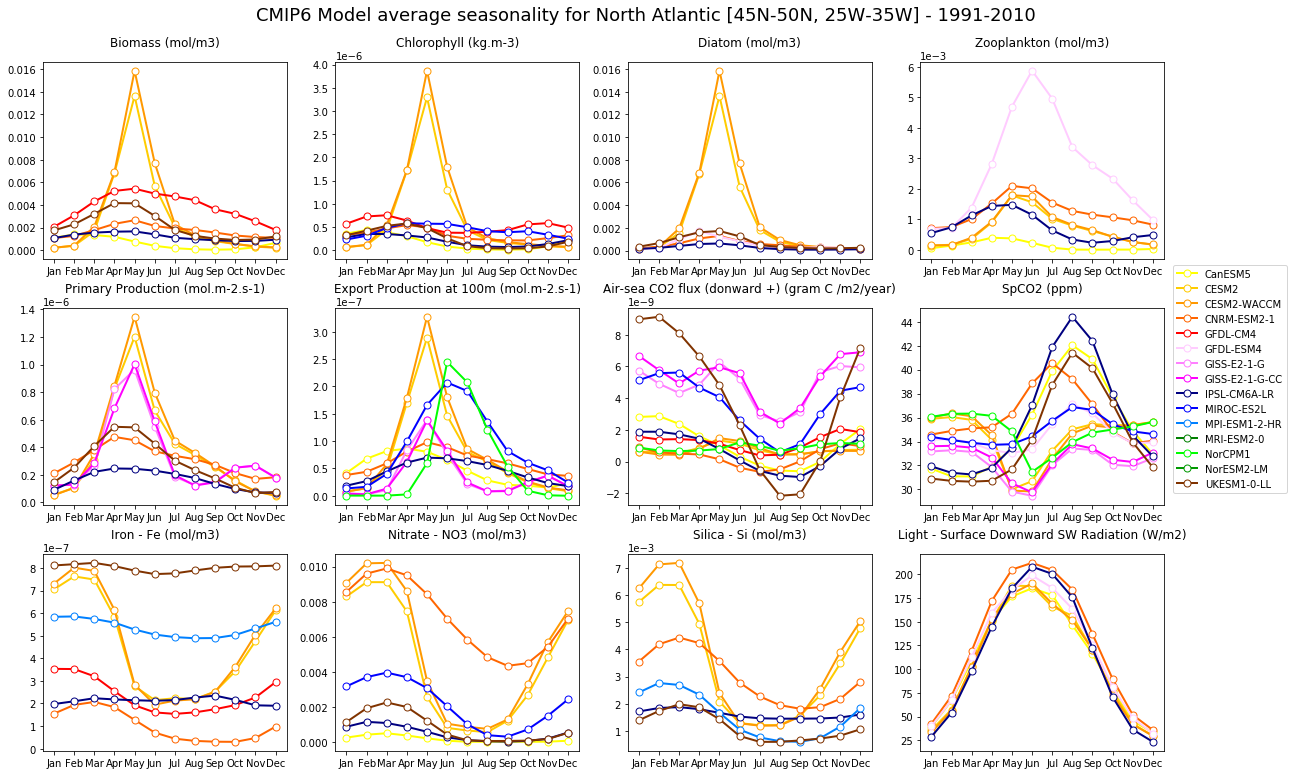

In [14]:
%%time

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 1

for var in var_names:
    
    ax = plt.subplot(ncol,nrow,i)
    i = i + 1
    
    mi = 0
    for model in data_na:
        xmon = np.arange(1, 13)
        dm = data_na[model]
        if var in dm:                
            s = dm[var]
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = dm[var] * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                #if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                    #s = []
                    #xmon = []
                    
                if var == 'intpp':
                    s = -dm[var]               # need more infromation
                if var == 'fgco2':
                    s = dm[var]*(10**(-10))    # need more infromation
                if var == 'dfe':
                    #s = dm[var] * 0.001        # need more infromation
                    s = []
                    xmon = []
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-2], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.35)) 
plt.suptitle('CMIP6 Model average seasonality for North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('MultiVar_NA.png', dpi=600)    


In [126]:
plot_ranges=[[-0.001,0.02], [-0.1e-6,5e-6], [-0.0005, 0.0175], [-0.0005,0.013], 
             [-0.05e-6,1.4e-6], [-0.1e-7,3.5e-7], [-30,85], [270,460],  
             [-0.1e-7,1e-6], [-0.001,0.012], [-0.001,0.016], [0,250]]

CPU times: user 6.96 s, sys: 226 ms, total: 7.18 s
Wall time: 7.06 s


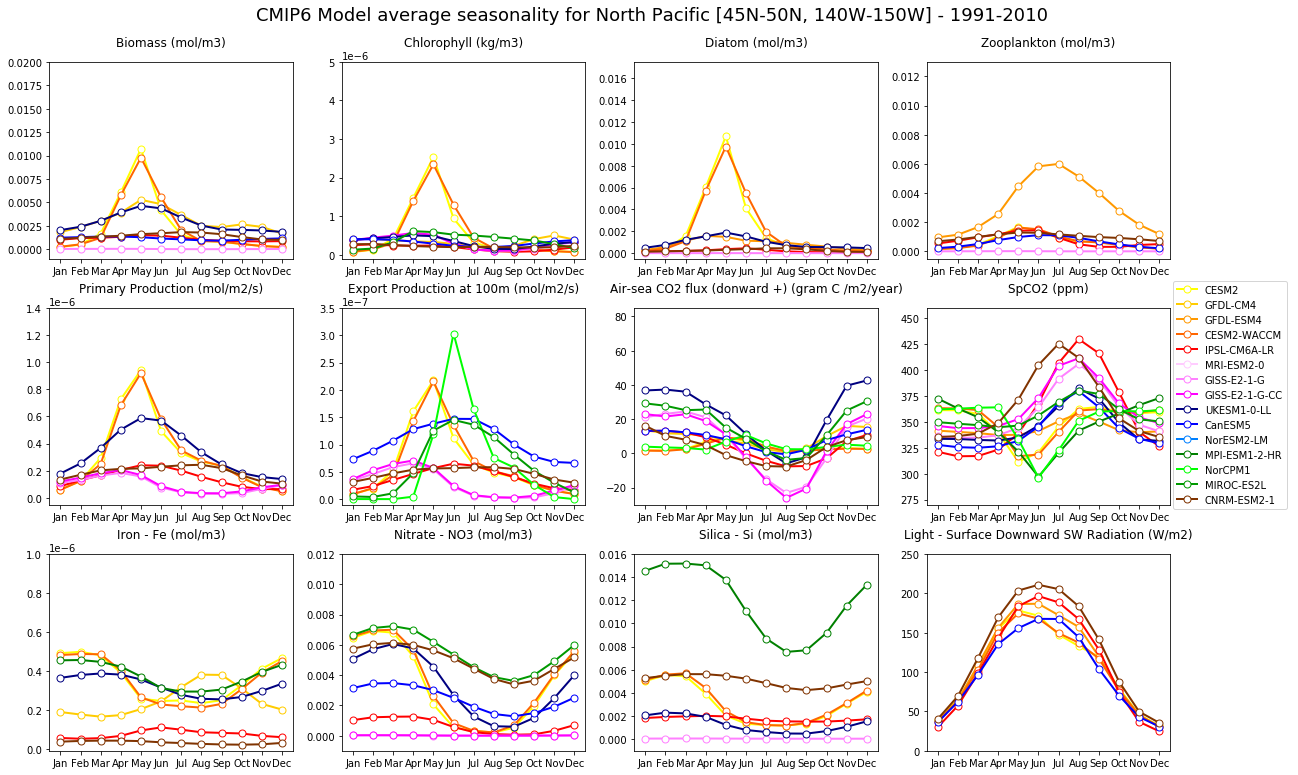

In [129]:
%%time

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 0
for var in var_names:
    
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
        
        ofn = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(plot_ranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('MultiVar_NP_new.png', dpi=600)    


CPU times: user 6.91 s, sys: 172 ms, total: 7.08 s
Wall time: 6.97 s


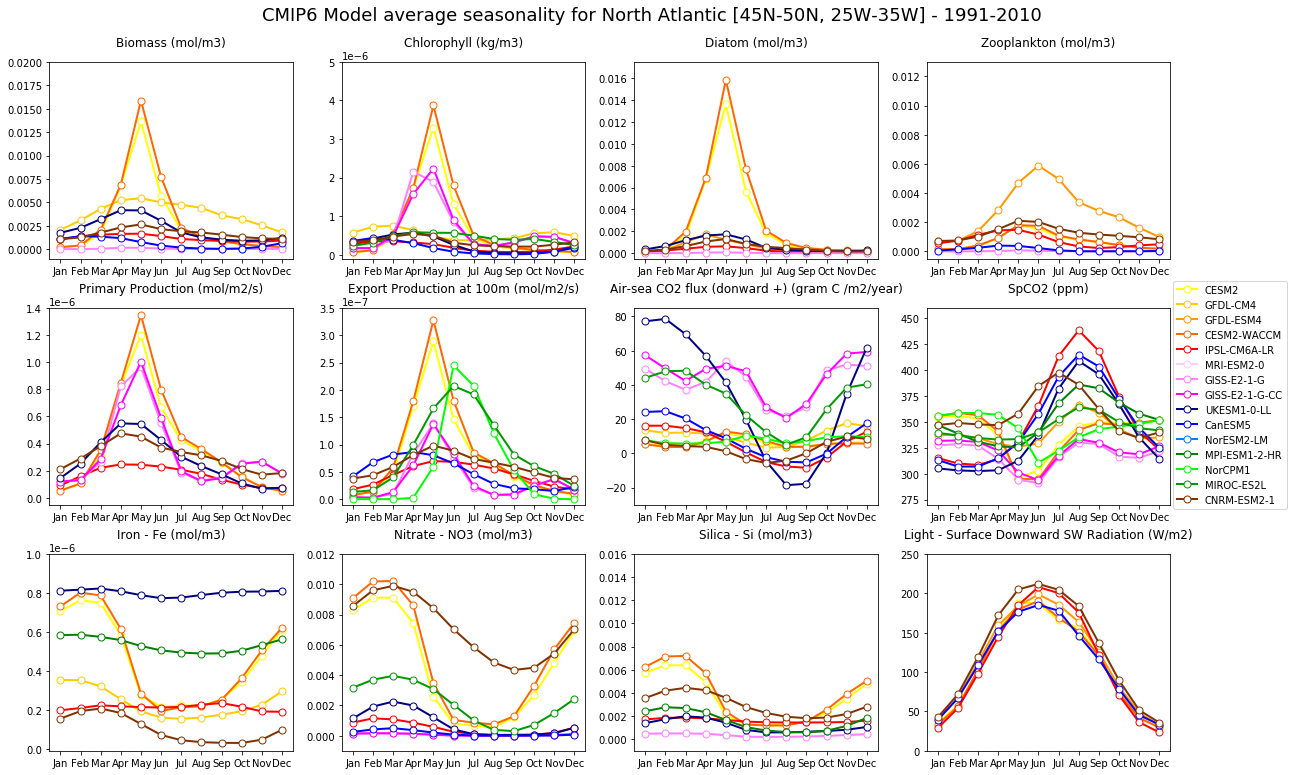

In [130]:
%%time

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 0
for var in var_names:
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
        
        ofn = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            s = np.array(dm)
            xmon = np.arange(1, 13)
            
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = np.array(dm) * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -np.array(dm)            # need more infromation
                if var == 'fgco2':
                    s = np.array(dm)*(10**(-10))    # need more infromation               
                if var == 'dfe':                   
                    #s = np.array(dm) * 0.001        # need more infromation
                    s = []
                    xmon = []
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(plot_ranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Atlantic [45N-50N, 25W-35W] - ' + str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('MultiVar_NA_new.png', dpi=600)    


# SpCO2 separation

In [57]:
models = ['NorCP1']

In [60]:
%%time

for model in models:
    sparay = get_data(df, 'spco2', model, expe, freq)
    #print(sparay)
    if isinstance(sparay, xr.Dataset):
        staray = get_data(df, 'tos', model, expe, freq)
        #print(staray)
        if not isinstance(staray, xr.Dataset):
            print(model, 'no tos, try thetao')
            staray = get_data(df, 'thetao', model, expe, freq)
            #print(staray)
            if not isinstance(staray, xr.Dataset):
                print(model, 'no sst data')
                continue
    else:
        continue
    
    dsp = sparay.sel(time=slice(start_year, end_year))['spco2']
    
    if 'thetao' in staray:
        if 'lev_partial' in staray.coords:
            staray = staray.isel(lev_partial=0)
        if 'olevel' in staray.coords:
            staray = staray.isel(olevel=0)
        if 'lev' in staray.coords:
            staray = staray.isel(lev=0)
        if 'rho' in staray.coords:
            staray = staray.isel(rho=0)
        dst = staray.sel(time=slice(start_year, end_year))['thetao']
        
        #dst = dst.rename({'thetao':'tos'})
    else:
        dst = staray.sel(time=slice(start_year, end_year))['tos']
        
    if dst.shape[0] != 240:
        continue
    
    
    if 'latitude' in dsp.coords:
        dsp = dsp.rename({'longitude': 'lon', 'latitude': 'lat'})
        dst = dst.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in dsp.coords:
        dsp = dsp.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        dst = dst.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
    mrp = xe.Regridder(dsp, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    mrp._grid_in = None
    mrp._grid_out = None
    dsp_out = mrp(dsp)
    mrt = xe.Regridder(dst, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    mrt._grid_in = None
    mrt._grid_out = None
    dst_out = mrt(dst)
    
    m_rg = xr.Dataset({'spco2':dsp_out, 'sst':dst_out})
    

    if m_rg['spco2'].shape[0]==240:
        if m_rg['sst'].shape[0]==240:
            print(m_rg['sst'].shape)
            
            ## PAPA site ##
            d_np = m_rg.sel(lat=slice(45,50)).sel(lon=slice(210,220))    
            
            msp_np = d_np['spco2'].mean(dim='time',skipna=1) 
            anomsp_np = d_np['spco2'] - msp_np
            mst_np = d_np['sst'].mean(dim='time',skipna=1)
            anomst_np = d_np['sst'] - mst_np
            
            anomsp_np.load()           
            anomsp_detrended_np = xr.apply_ufunc(detrend, anomsp_np.fillna(0), 
                                                 kwargs={'axis': 0}).where(~anomsp_np.isnull())
            dtsp_np = anomsp_detrended_np + msp_np   
            dtsp_np = dtsp_np / 0.101325 
            
            anomst_np.load()
            anomst_detrended_np = xr.apply_ufunc(detrend, anomst_np.fillna(0), 
                                                 kwargs={'axis': 0}).where(~anomst_np.isnull())
            dtst_np = anomst_detrended_np + mst_np      
            
            sp_temp_np = np.mean(dtsp_np) * np.exp(0.0423 * anomst_detrended_np)
            sp_ntemp_np = dtsp_np * np.exp( 0.0423 * (- anomst_detrended_np))       
            
            monsp_t_np = sp_temp_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            monsp_nt_np = sp_ntemp_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            sst_np = dtst_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values               
            
            savet_np = 'save/' + model + '_pco2-t_np.txt'
            with open(savet_np, 'w') as nptf:
                for idata in monsp_t_np:
                    nptf.write(str(idata) +"\n")        
            
            savent_np = 'save/' + model + '_pco2-nt_np.txt'
            with open(savent_np, 'w') as npntf:
                for idata in monsp_nt_np:
                    npntf.write(str(idata) +"\n")
            
            savesst_np = 'save/' + model + '_sst_np.txt'
            with open(savesst_np, 'w') as npsstf:
                for idata in sst_np:
                    npsstf.write(str(idata) +"\n")
                    
            
            ## NABA site ##
            d_na = m_rg.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            
            msp_na = d_na['spco2'].mean(dim='time',skipna=1)
            anomsp_na = d_na['spco2'] - msp_na
            mst_na = d_na['sst'].mean(dim='time',skipna=1)
            anomst_na = d_na['sst'] - mst_na
            
            anomsp_na.load()
            anomsp_detrended_na = xr.apply_ufunc(detrend, anomsp_na.fillna(0), kwargs={'axis': 0}).where(~anomsp_na.isnull())
            dtsp_na = anomsp_detrended_na + msp_na
            dtsp_na = dtsp_na / 0.101325 
            
            anomst_na.load()
            anomst_detrended_na = xr.apply_ufunc(detrend, anomst_na.fillna(0), kwargs={'axis': 0}).where(~anomst_na.isnull())
            dtst_na = anomst_detrended_na + mst_na
            
            sp_temp_na = np.mean(dtsp_na) * np.exp(0.0423 * anomst_na)
            sp_ntemp_na = dtsp_na * np.exp( 0.0423 * (- anomst_na))
            
            monsp_t_na = sp_temp_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            monsp_nt_na = sp_ntemp_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            sst_na = dtst_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savet_na = 'save/' + model + '_pco2-t_na.txt'
            with open(savet_na, 'w') as natf:
                for idata in monsp_t_na:
                    natf.write(str(idata) +"\n")
            
            savent_na = 'save/' + model + '_pco2-nt_na.txt'
            with open(savent_na, 'w') as nantf:
                for idata in monsp_nt_na:
                    nantf.write(str(idata) +"\n")
            
            savesst_na = 'save/' + model + '_sst_na.txt'
            with open(savesst_na, 'w') as nasstf:
                for idata in sst_na:
                    nasstf.write(str(idata) +"\n")
    
    
    mrp.clean_weight_file()
    mrt.clean_weight_file()

CanESM5 spco2 found data
CanESM5 tos found data
Create weight file: bilinear_291x360_181x361_peri.nc
Overwrite existing file: bilinear_291x360_181x361_peri.nc 
 You can set reuse_weights=True to save computing time.
(240, 181, 361)
Remove file bilinear_291x360_181x361_peri.nc
File bilinear_291x360_181x361_peri.nc is already removed.
CESM2 spco2 found data
CESM2 tos found data
Overwrite existing file: bilinear_384x320_181x361_peri.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_384x320_181x361_peri.nc 
 You can set reuse_weights=True to save computing time.
(240, 181, 361)
Remove file bilinear_384x320_181x361_peri.nc
File bilinear_384x320_181x361_peri.nc is already removed.
CESM2-WACCM spco2 found data
CESM2-WACCM tos found data
Create weight file: bilinear_180x360_181x361_peri.nc
Overwrite existing file: bilinear_180x360_181x361_peri.nc 
 You can set reuse_weights=True to save computing time.
(240, 181, 361)
Remove file bilinear_180x360_181

In [7]:
pvars=['spco2', 'pco2-t', 'pco2-nt',
       'chl', 'sst', 'phyc',
       'dfe','no3']
ptitles=['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)', 
         'Chlorophyll (kg/m3)', 'SST (C)', 'Biomass (mol/m3)',
         'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)']  
pranges=[[270, 485], [270, 485], [270, 485], 
         [-0.1e-6, 5e-6], [4, 20], [-0.001,0.02],
         [-0.1e-6, 1e-6], [-0.001, 0.012]]

CPU times: user 5.25 s, sys: 104 ms, total: 5.35 s
Wall time: 5.29 s


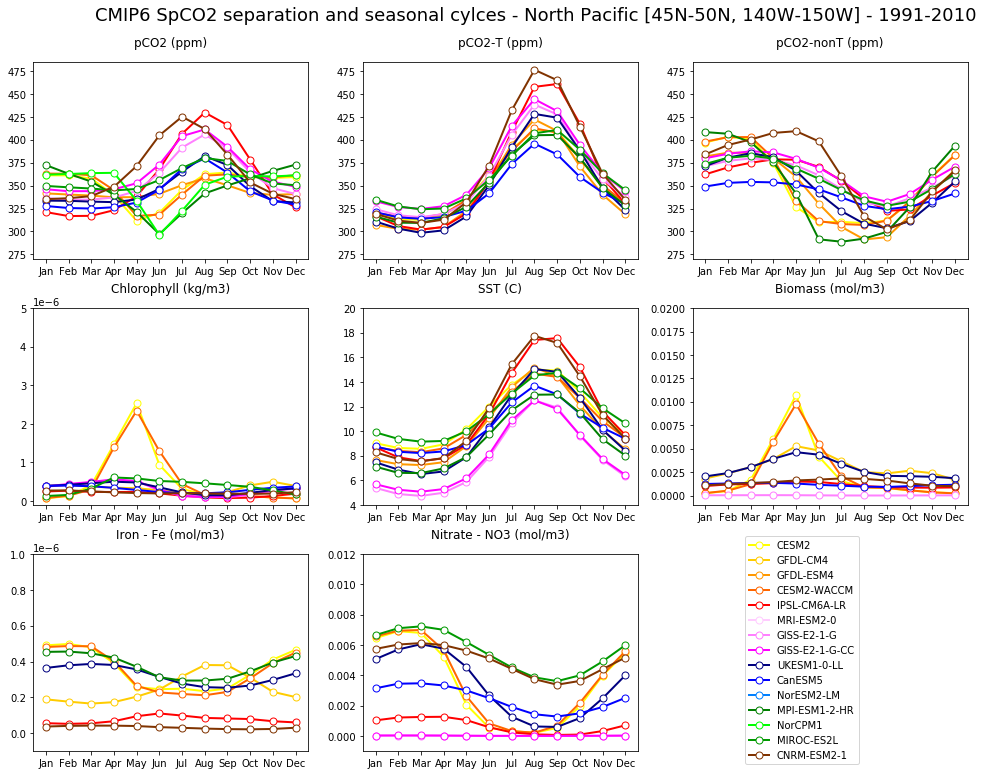

In [132]:
%%time

fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 3
i = 0
for var in pvars:
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
        
        ofn = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.8, 0.01)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_NP.png', dpi=600)    


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


CPU times: user 5.51 s, sys: 485 ms, total: 5.99 s
Wall time: 5.95 s


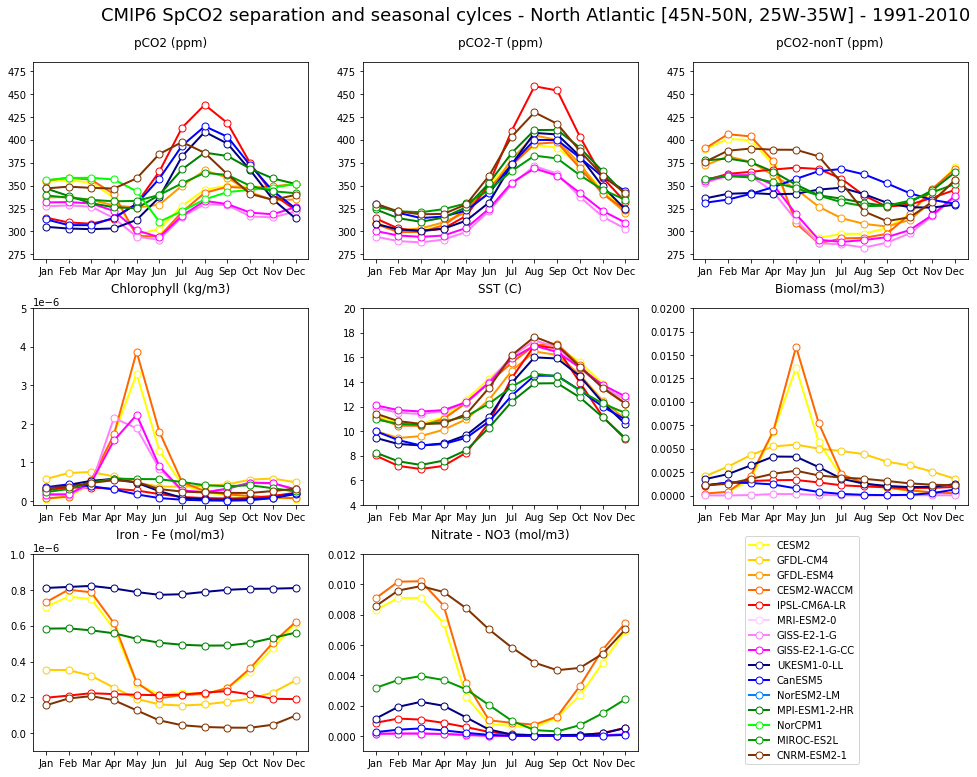

In [8]:
%%time

fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 3
i = 0
for var in pvars:
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
        
        ofn = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            s = np.array(dm)
            xmon = np.arange(1, 13)
            
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = np.array(dm) * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -np.array(dm)            # need more infromation
                if var == 'fgco2':
                    s = np.array(dm)*(10**(-10))    # need more infromation               
                if var == 'dfe':                   
                    #s = np.array(dm) * 0.001        # need more infromation
                    s = []
                    xmon = []
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.8, 0.01)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Atlantic [45N-50N, 25W-35W] - ' + str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_NA.png', dpi=600)    


# Average parameter value

In [21]:
var_names=['phyc','chl','phydiat','zooc',
           'intpp','epc100','sst','mld',
           'fgco2','spco2','pco2-t','pco2-nt',
           'dfe','no3','si','rsntds']
plot_titles=['Biomass (mol/m3)','Chlorophyll (kg.m-3)','Diatom (mol/m3)', 'Zooplankton (mol/m3)',
             'Primary Prod. (mol.m-2.s-1)','Export Prod. (mol.m-2.s-1)',   'SST (C)',   'MLD (m)', 
             'Air-sea CO2 flux(gram C /m2/year)', 'SpCO2 (ppm)', 'SpCO2-T (ppm)', 'SpCO2-nonT (ppm)', 
             'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light (W/m2)']  
plot_ranges=[[-0.0005,0.005], [-0.1e-6,1e-6],  [-0.0005, 0.0045],  [-0.001,0.005], 
             [-0.05e-6,0.6e-6], [-0.1e-7,1.5e-7], [6,15], [-1,450], 
             [-5,60], [310,380], [310,380], [310,380], 
             [-0.1e-6,1e-6], [-0.001,0.01], [-0.0025,0.015], [90,160]]

CPU times: user 7.96 s, sys: 1.86 s, total: 9.81 s
Wall time: 7.54 s


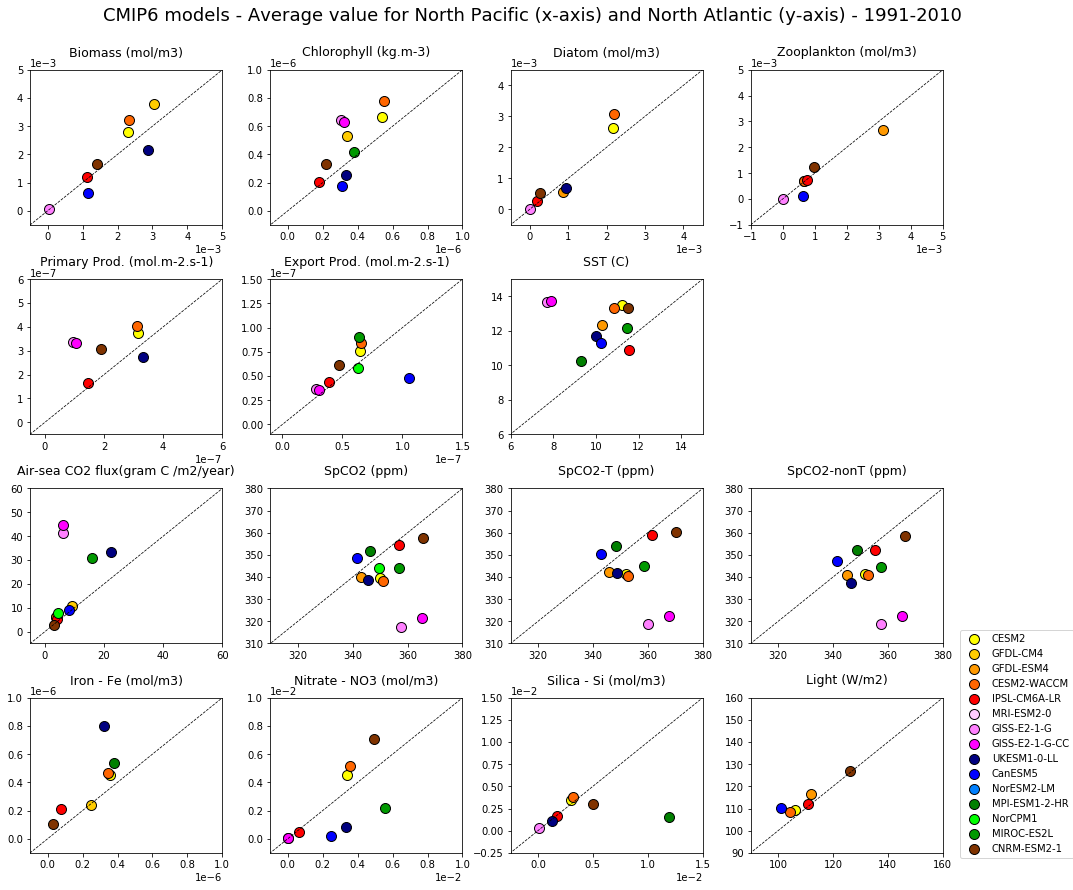

In [22]:
%%time

fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var_names:
    i = i + 1
    if var == 'mld':
        continue
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        np_value = np_value * 0.001        # need more infromation
                        na_value = na_value * 0.001
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        np_value = -np_value             # need more infromation
                        na_value = -na_value
                    if var == 'fgco2':                  
                        np_value = np_value*(10**(-10))    # need more infromation
                        na_value = na_value*(10**(-10))
                    if var == 'dfe':
                        np_value = []
                        na_value = []        # need more infromation                                           
                        
                h = plt.scatter(np.mean(np_value), np.mean(na_value), s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    
    plt.ylim(plot_ranges[i-1])
    plt.xlim(plot_ranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,1000))
    plt.title(plot_titles[i-1], fontsize=12.5, y=1.05)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.35, wspace=0.25) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Average value for North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NA_NP_average.png', dpi=600)    


In [20]:
mmranges = [[-1,7.5], [-1,7.5],  [-1,7.5],  [-1,5], 
             [-1,5], [-1,7.5], [0,2], [-1,450], 
             [-1,10], [-0.1,0.8], [-0.1,0.8], [-0.1,0.8], 
             [-0.1,2.5], [-0.1,4], [-0.1,2.5], [-0.1,2.2]]

In [23]:
# Behzad's range
mmranges = [[-0.01,9], [-0.01,9], [-0.01,9], [-0.01,9],
            [-0.01,4.7], [-0.01,4.7], [-0.01,1.3], [-1,9],     
            [-1,25], [-0.01,0.5], [-0.01,0.5], [-0.01,0.5], 
            [-0.01,2.3], [-0.01,4], [-0.01,2.3], [-0.01,2.3]]

CPU times: user 7.7 s, sys: 1.75 s, total: 9.45 s
Wall time: 7.16 s


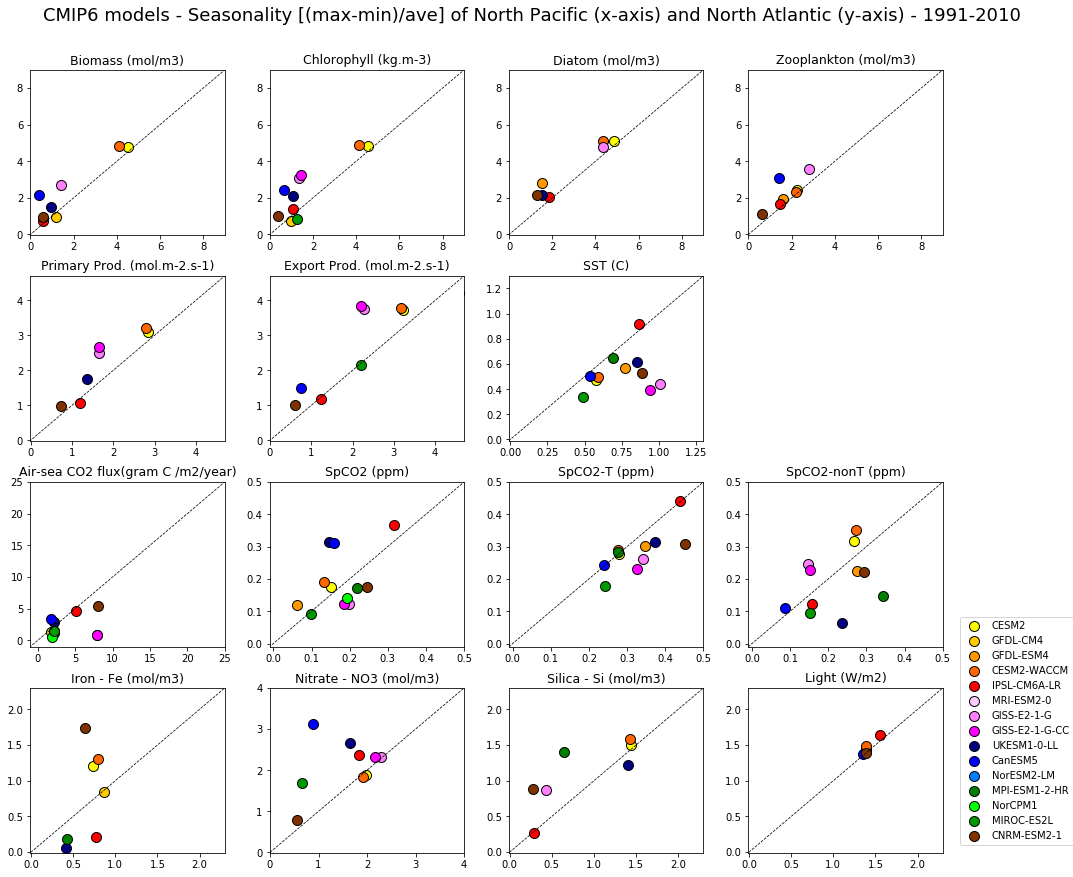

In [26]:
%%time

fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var_names:
    i = i + 1
    if var == 'mld':
        continue
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        np_value = np_value * 0.001        # need more infromation
                        na_value = na_value * 0.001
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        np_value = -np_value             # need more infromation
                        na_value = -na_value
                    if var == 'fgco2':                  
                        np_value = np_value*(10**(-10))    # need more infromation
                        na_value = na_value*(10**(-10))
                    if var == 'dfe':
                        np_value = []
                        na_value = []        # need more infromation                                           
                
                if np.shape(np_value)[0] > 0:
                    np_plot = (np.nanmax(np_value) - np.nanmin(np_value)) / np.nanmean(np_value)
                    na_plot = (np.nanmax(na_value) - np.nanmin(na_value)) / np.nanmean(na_value)
                    
                    h = plt.scatter(np_plot, na_plot, s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
                else:
                    h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    plt.ylim(mmranges[i-1])
    plt.xlim(mmranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12.5, y=1)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.25, wspace=0.23) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Seasonality [(max-min)/ave] of North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NA_NP_max-min_ave.png', dpi=600)    


# pCO2 separation (model by model)


In [27]:
n=0
for model in models:
    ofn = 'save/' + str(model) + '_pco2-t_np.txt'
    if os.path.exists(ofn):
        n = n +1

n

11

CPU times: user 6.48 s, sys: 520 ms, total: 7 s
Wall time: 6.79 s


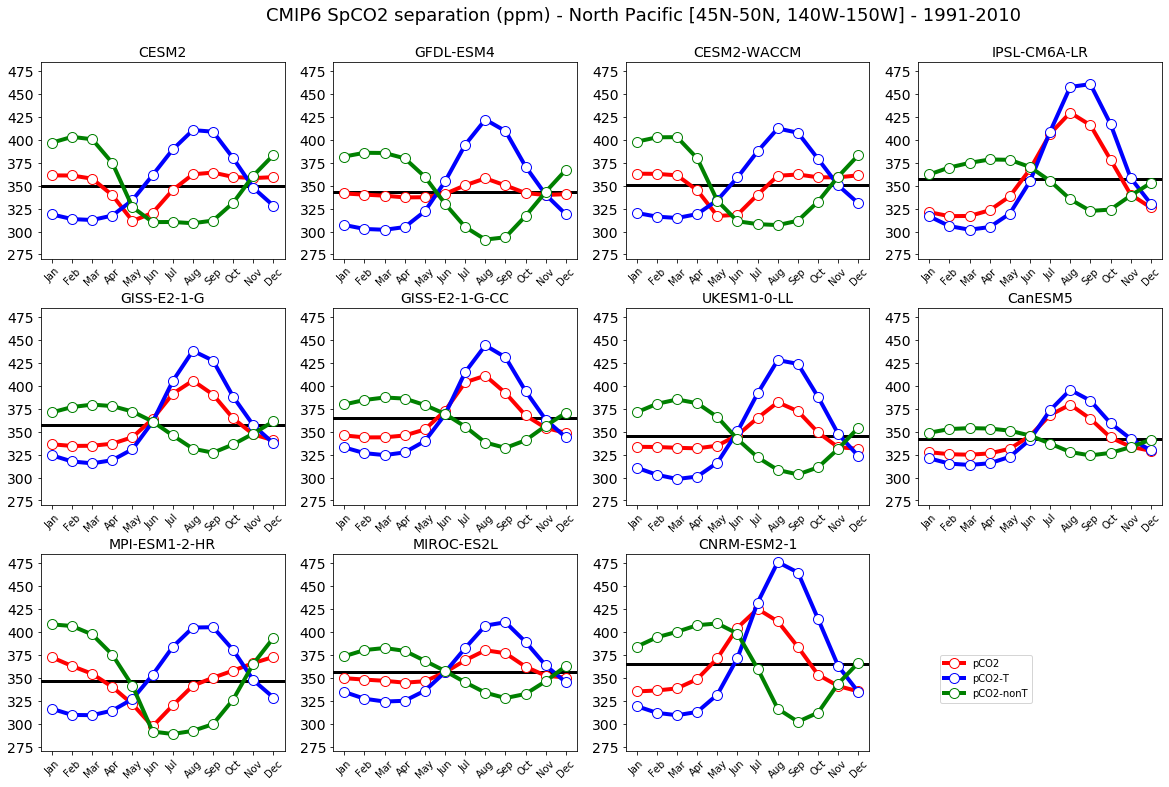

In [45]:
%%time

## PAPA


fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 0
for model in models:
    
    f_pt = 'save/' + str(model) + '_pco2-t_np.txt'
    f_pnt = 'save/' + str(model) + '_pco2-nt_np.txt'
    f_p = 'save/' + str(model) + '_spco2_np.txt'
    
    if os.path.exists(f_pt):
        
        pco2_t = []
        with open(f_pt, "r") as rf:
            for line in rf:
                pco2_t.append(float(line.strip()))
        pco2_nt = []
        with open(f_pnt, "r") as rf:
            for line in rf:
                pco2_nt.append(float(line.strip()))
        pco2 = []
        with open(f_p, "r") as rf:
            for line in rf:
                pco2.append(float(line.strip()))
        
        xmon = np.arange(1, 13)
        
        i = i + 1
        ax = plt.subplot(ncol,nrow,i)
        
        plt.axhline(y=np.nanmean(pco2), color='k', linewidth=3.0)
        l1, = plt.plot(xmon, pco2, c='r', label='pCO2', 
                      marker='o', markersize=10, markerfacecolor='W', linewidth=4.0)
        l2, = plt.plot(xmon, pco2_t, c='b', label='pCO2-T', 
                      marker='o', markersize=10, markerfacecolor='W', linewidth=4.0)
        l3, = plt.plot(xmon, pco2_nt, c='g', label='pCO2-nonT',
                      marker='o', markersize=10, markerfacecolor='W', linewidth=4.0)
        plt.yticks(fontsize = 14)
        plt.ylim(270, 485)
        plt.xticks(xmon, Time_months, rotation=45, fontsize=10) # Setting the X-ticks ## rotation='horizontal' # rotation='vertical'    
        plt.title(str(model), fontsize=14)
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend([l1,l2,l3], ['pCO2', 'pCO2-T', 'pCO2-nonT'], loc='lower right', bbox_to_anchor=(0.8, 0.10)) 
plt.suptitle('CMIP6 SpCO2 separation (ppm) - North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_model_NP.png', dpi=600)    


CPU times: user 6.98 s, sys: 468 ms, total: 7.45 s
Wall time: 7.32 s


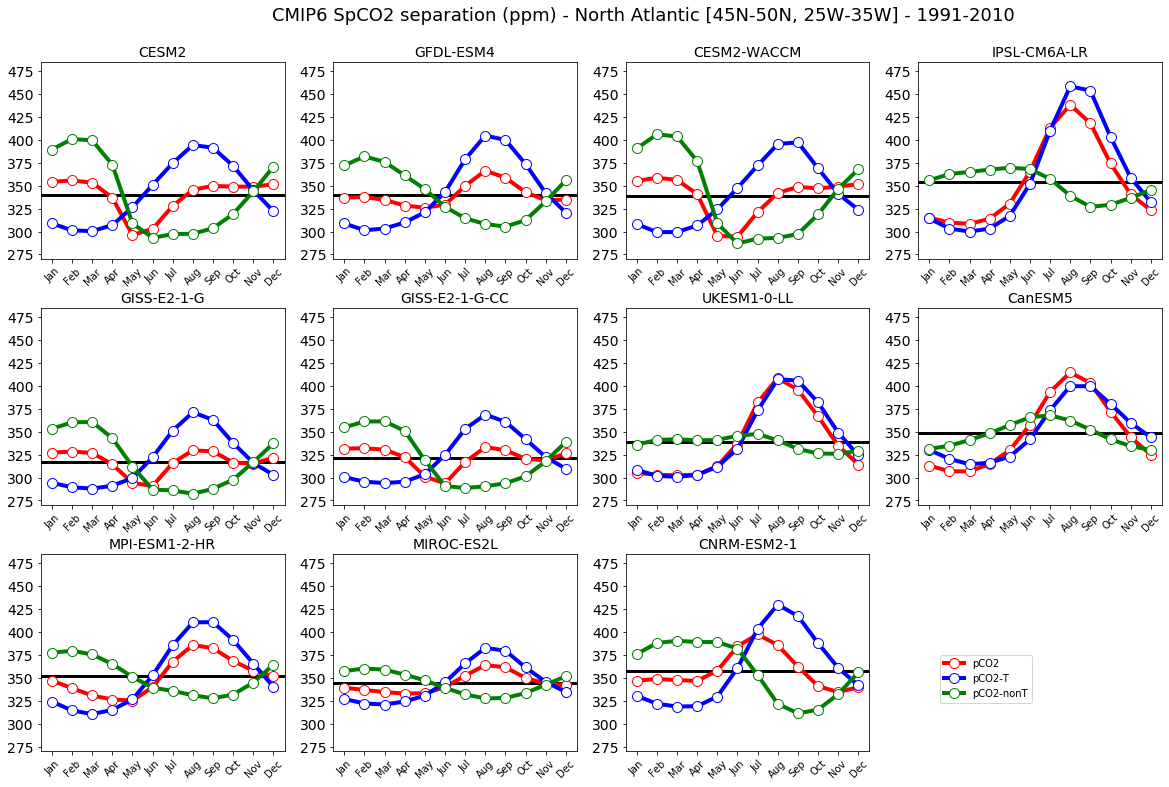

In [46]:
%%time

## NAPA

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 0

for model in models:
    
    f_pt = 'save/' + str(model) + '_pco2-t_na.txt'
    f_pnt = 'save/' + str(model) + '_pco2-nt_na.txt'
    f_p = 'save/' + str(model) + '_spco2_na.txt'
    
    if os.path.exists(f_pt):
        
        pco2_t = []
        with open(f_pt, "r") as rf:
            for line in rf:
                pco2_t.append(float(line.strip()))
        pco2_nt = []
        with open(f_pnt, "r") as rf:
            for line in rf:
                pco2_nt.append(float(line.strip()))
        pco2 = []
        with open(f_p, "r") as rf:
            for line in rf:
                pco2.append(float(line.strip()))
        
        xmon = np.arange(1, 13)
        
        i = i + 1
        ax = plt.subplot(ncol,nrow,i)
        
        plt.axhline(y=np.nanmean(pco2), color='k', linewidth=3.0)
        l1, = plt.plot(xmon, pco2, c='r', label='pCO2', 
                      marker='o', markersize=10, markerfacecolor='W', linewidth=4.0)
        l2, = plt.plot(xmon, pco2_t, c='b', label='pCO2-T', 
                      marker='o', markersize=10, markerfacecolor='W', linewidth=4.0)
        l3, = plt.plot(xmon, pco2_nt, c='g', label='pCO2-nonT',
                      marker='o', markersize=10, markerfacecolor='W', linewidth=4.0)
        plt.yticks(fontsize = 14)
        plt.ylim(270, 485)
        plt.xticks(xmon, Time_months, rotation=45, fontsize=10) # Setting the X-ticks ## rotation='horizontal' # rotation='vertical'    
        plt.title(str(model), fontsize=14)
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend([l1,l2,l3], ['pCO2', 'pCO2-T', 'pCO2-nonT'], loc='lower right', bbox_to_anchor=(0.8, 0.10)) 
plt.suptitle('CMIP6 SpCO2 separation (ppm) - North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_model_NA.png', dpi=600)    


# Zoo / biomass & Diatom / biomass

In [54]:
for model in models:
    
    paray = get_data(df, 'phyc', model, expe, freq)
    if not isinstance(paray, xr.Dataset):
        continue
    
    n = 0
    zaray = get_data(df, 'zooc', model, expe, freq)
    daray = get_data(df, 'phydiat', model, expe, freq)
    if isinstance(zaray, xr.Dataset):
        n = n + 1
    if isinstance(daray, xr.Dataset):
        n = n + 1
    print(model, n)

CESM2 phyc found data
CESM2 zooc found data
CESM2 phydiat found data
CESM2 2
GFDL-CM4 phyc found data
GFDL-CM4 0
CESM2-WACCM phyc found data
CESM2-WACCM zooc found data
CESM2-WACCM phydiat found data
CESM2-WACCM 2
IPSL-CM6A-LR phyc found data
IPSL-CM6A-LR zooc found data
IPSL-CM6A-LR phydiat found data
IPSL-CM6A-LR 2
GISS-E2-1-G phyc found data
GISS-E2-1-G zooc found data
GISS-E2-1-G phydiat found data
GISS-E2-1-G 2
UKESM1-0-LL phyc found data
UKESM1-0-LL phydiat found data
UKESM1-0-LL 1
CanESM5 phyc found data
CanESM5 zooc found data
CanESM5 1
CNRM-ESM2-1 phyc found data
CNRM-ESM2-1 zooc found data
CNRM-ESM2-1 phydiat found data
CNRM-ESM2-1 2


In [73]:
# temp test
models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
          'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
          'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L']

In [74]:
%%time

for model in models:
    
    paray = get_data(df, 'phyc', model, expe, freq)
    if not isinstance(paray, xr.Dataset):
        continue
    
    n = 0
    zaray = get_data(df, 'zooc', model, expe, freq)
    daray = get_data(df, 'phydiat', model, expe, freq)
    if isinstance(zaray, xr.Dataset):
        n = n + 1
    if isinstance(daray, xr.Dataset):
        n = n + 1
    
    if n == 0:
        continue            
            
    dp = paray.sel(time=slice(start_year, end_year))['phyc']
    
    if 'lev_partial' in dp.coords:
        dp = dp.isel(lev_partial=0)
    if 'olevel' in dp.coords:
        dp = dp.isel(olevel=0)
    if 'lev' in dp.coords:
        dp = dp.isel(lev=0)
    
    if 'latitude' in dp.coords:
        dp = dp.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in dp.coords:
        dp = dp.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
    regridder = xe.Regridder(dp, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    regridder._grid_in = None
    regridder._grid_out = None
    
    if isinstance(zaray, xr.Dataset):
        dz = zaray.sel(time=slice(start_year, end_year))['zooc']
        
        if 'lev_partial' in dz.coords:
            dz = dz.isel(lev_partial=0)
        if 'olevel' in dz.coords:
            dz = dz.isel(olevel=0)
        if 'lev' in dz.coords:
            dz = dz.isel(lev=0)
            
        if 'latitude' in dz.coords:
            dz = dz.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in dz.coords:
            dz = dz.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        
        zp_ratio = dz/dp
        
        
        zp_ratio_out = regridder(zp_ratio)
        zpr = xr.Dataset({'zpr':zp_ratio_out})
        
        if zpr['zpr'].shape[0]==240:
            #PAPA
            zpr_np = zpr.sel(lat=slice(45,50)).sel(lon=slice(210,220))
            
            mzpr_np = zpr_np['zpr'].mean(dim='time', skipna=1)
            anomzpr_np = zpr_np['zpr'] - mzpr_np
            anomzpr_np.load()
            anomzpr_detrended_np = xr.apply_ufunc(detrend, anomzpr_np, 
                                                 kwargs={'axis': 0}).where(~anomzpr_np.isnull())
            zpr_detrend_np = anomzpr_detrended_np + mzpr_np
            vzpr_np = zpr_detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_np = 'save/' + model + '_zpr_np.txt'
            with open(savef_np, 'w') as npf:
                for idata in vzpr_np:
                    npf.write(str(idata) +"\n")
            
            #NABA
            zpr_na = zpr.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            mzpr_na = zpr_na['zpr'].mean(dim='time',skipna=1)
            anomzpr_na = zpr_na['zpr'] - mzpr_na
            anomzpr_na.load()
            anomzpr_detrended_na = xr.apply_ufunc(detrend, anomzpr_na,
                                                 kwargs={'axis': 0}).where(~anomzpr_na.isnull())
            zpr_detrend_na = anomzpr_detrended_na + mzpr_na
            vzpr_na = zpr_detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_na = 'save/' + model + '_zpr_na.txt'
            with open(savef_na, 'w') as naf:
                for idata in vzpr_na:
                    naf.write(str(idata) +"\n")
                        
    if isinstance(daray, xr.Dataset):
        dd = daray.sel(time=slice(start_year, end_year))['phydiat']
        
        if 'lev_partial' in dd.coords:
            dd = dd.isel(lev_partial=0)
        if 'olevel' in dd.coords:
            dd = dd.isel(olevel=0)
        if 'lev' in dz.coords:
            dd = dd.isel(lev=0)
            
        if 'latitude' in dd.coords:
            dd = dd.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in dd.coords:
            dd = dd.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        
        d_frac = dd/dp
        
        d_frac_out = regridder(d_frac)
        dfrac = xr.Dataset({'dfrac':d_frac_out})
        
        if dfrac['dfrac'].shape[0]==240:
            #PAPA
            df_np = dfrac.sel(lat=slice(45,50)).sel(lon=slice(210,220))
            mdf_np = df_np['dfrac'].mean(dim='time', skipna=1)
            anomdf_np = df_np['dfrac'] - mdf_np
            anomdf_np.load()
            anomdf_detrended_np = xr.apply_ufunc(detrend, anomdf_np, 
                                                 kwargs={'axis': 0}).where(~anomdf_np.isnull())
            df_detrend_np = anomdf_detrended_np + mdf_np
            vdf_np = df_detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_np = 'save/' + model + '_dfrac_np.txt'
            with open(savef_np, 'w') as npf:
                for idata in vdf_np:
                    npf.write(str(idata) +"\n")
            
            #NABA
            df_na = dfrac.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            mdf_na = df_na['dfrac'].mean(dim='time',skipna=1)
            anomdf_na = df_na['dfrac'] - mdf_na
            anomdf_na.load()
            anomdf_detrended_na = xr.apply_ufunc(detrend, anomdf_na,
                                                 kwargs={'axis': 0}).where(~anomdf_na.isnull())
            df_detrend_na = anomdf_detrended_na + mdf_na
            vdf_na = df_detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_na = 'save/' + model + '_dfrac_na.txt'
            with open(savef_na, 'w') as naf:
                for idata in vdf_na:
                    naf.write(str(idata) +"\n")
    
    regridder.clean_weight_file()


CESM2 phyc found data
CESM2 zooc found data
CESM2 phydiat found data
Create weight file: bilinear_384x320_181x361_peri.nc


distributed.scheduler - INFO - Register tcp://10.32.7.8:38891
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.7.8:38891
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.9.4:39073
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.9.4:39073
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.8.4:43685
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.4:43685
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.8.3:44551
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.3:44551
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.21.11:41367
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.21.11:41367
distributed.core - INFO - Sta

Remove file bilinear_384x320_181x361_peri.nc
GFDL-CM4 phyc found data
CESM2-WACCM phyc found data
CESM2-WACCM zooc found data
CESM2-WACCM phydiat found data
Create weight file: bilinear_384x320_181x361_peri.nc


distributed.scheduler - INFO - Retire worker names (32, 33, 34, 35, 36, 29)
distributed.deploy.adaptive - INFO - Retiring workers [32, 33, 34, 35, 36, 29]
distributed.scheduler - INFO - Remove worker tcp://10.32.7.8:38891
distributed.core - INFO - Removing comms to tcp://10.32.7.8:38891
distributed.scheduler - INFO - Remove worker tcp://10.32.20.8:33641
distributed.core - INFO - Removing comms to tcp://10.32.20.8:33641
distributed.scheduler - INFO - Remove worker tcp://10.32.8.4:43685
distributed.core - INFO - Removing comms to tcp://10.32.8.4:43685
distributed.scheduler - INFO - Remove worker tcp://10.32.8.3:44551
distributed.core - INFO - Removing comms to tcp://10.32.8.3:44551
distributed.scheduler - INFO - Remove worker tcp://10.32.21.12:33215
distributed.core - INFO - Removing comms to tcp://10.32.21.12:33215
distributed.scheduler - INFO - Remove worker tcp://10.32.21.11:41367
distributed.core - INFO - Removing comms to tcp://10.32.21.11:41367
distributed.scheduler - INFO - Regist

Remove file bilinear_384x320_181x361_peri.nc
IPSL-CM6A-LR phyc found data
IPSL-CM6A-LR zooc found data
IPSL-CM6A-LR phydiat found data
Create weight file: bilinear_332x362_181x361_peri.nc


distributed.scheduler - INFO - Retire worker names (36, 37, 38, 39, 40, 41)
distributed.deploy.adaptive - INFO - Retiring workers [36, 37, 38, 39, 40, 41]
distributed.scheduler - INFO - Remove worker tcp://10.32.6.9:35825
distributed.core - INFO - Removing comms to tcp://10.32.6.9:35825
distributed.scheduler - INFO - Remove worker tcp://10.32.7.9:36087
distributed.core - INFO - Removing comms to tcp://10.32.7.9:36087
distributed.scheduler - INFO - Remove worker tcp://10.32.8.5:33223
distributed.core - INFO - Removing comms to tcp://10.32.8.5:33223
distributed.scheduler - INFO - Remove worker tcp://10.32.21.13:36533
distributed.core - INFO - Removing comms to tcp://10.32.21.13:36533
distributed.scheduler - INFO - Remove worker tcp://10.32.21.14:44343
distributed.core - INFO - Removing comms to tcp://10.32.21.14:44343
distributed.scheduler - INFO - Remove worker tcp://10.32.20.9:37881
distributed.core - INFO - Removing comms to tcp://10.32.20.9:37881
distributed.scheduler - INFO - Regist

Remove file bilinear_332x362_181x361_peri.nc
GISS-E2-1-G phyc found data
GISS-E2-1-G zooc found data
GISS-E2-1-G phydiat found data
Create weight file: bilinear_180x288_181x361_peri.nc


distributed.scheduler - INFO - Retire worker names (41, 42, 43, 44, 45, 46)
distributed.deploy.adaptive - INFO - Retiring workers [41, 42, 43, 44, 45, 46]
distributed.scheduler - INFO - Remove worker tcp://10.32.7.10:34205
distributed.core - INFO - Removing comms to tcp://10.32.7.10:34205
distributed.scheduler - INFO - Remove worker tcp://10.32.8.6:46401
distributed.core - INFO - Removing comms to tcp://10.32.8.6:46401
distributed.scheduler - INFO - Remove worker tcp://10.32.6.10:45487
distributed.core - INFO - Removing comms to tcp://10.32.6.10:45487
distributed.scheduler - INFO - Remove worker tcp://10.32.20.10:41035
distributed.core - INFO - Removing comms to tcp://10.32.20.10:41035
distributed.scheduler - INFO - Remove worker tcp://10.32.21.15:44731
distributed.core - INFO - Removing comms to tcp://10.32.21.15:44731
distributed.scheduler - INFO - Remove worker tcp://10.32.21.16:40301
distributed.core - INFO - Removing comms to tcp://10.32.21.16:40301
distributed.scheduler - INFO - 

Remove file bilinear_180x288_181x361_peri.nc
UKESM1-0-LL phyc found data
UKESM1-0-LL phydiat found data
Create weight file: bilinear_330x360_181x361_peri.nc


distributed.scheduler - INFO - Retire worker names (46, 47, 48, 49, 50, 51)
distributed.deploy.adaptive - INFO - Retiring workers [46, 47, 48, 49, 50, 51]
distributed.scheduler - INFO - Remove worker tcp://10.32.9.5:35991
distributed.core - INFO - Removing comms to tcp://10.32.9.5:35991
distributed.scheduler - INFO - Remove worker tcp://10.32.20.11:36339
distributed.core - INFO - Removing comms to tcp://10.32.20.11:36339
distributed.scheduler - INFO - Remove worker tcp://10.32.7.11:45497
distributed.core - INFO - Removing comms to tcp://10.32.7.11:45497
distributed.scheduler - INFO - Remove worker tcp://10.32.21.17:34465
distributed.core - INFO - Removing comms to tcp://10.32.21.17:34465
distributed.scheduler - INFO - Remove worker tcp://10.32.21.18:36349
distributed.core - INFO - Removing comms to tcp://10.32.21.18:36349
distributed.scheduler - INFO - Remove worker tcp://10.32.7.12:44563
distributed.core - INFO - Removing comms to tcp://10.32.7.12:44563
distributed.scheduler - INFO - 

Remove file bilinear_330x360_181x361_peri.nc
CanESM5 phyc found data
CanESM5 zooc found data
Create weight file: bilinear_291x360_181x361_peri.nc


distributed.scheduler - INFO - Retire worker names (51, 52, 53, 54, 55, 56)
distributed.deploy.adaptive - INFO - Retiring workers [51, 52, 53, 54, 55, 56]
distributed.scheduler - INFO - Remove worker tcp://10.32.7.13:41469
distributed.core - INFO - Removing comms to tcp://10.32.7.13:41469
distributed.scheduler - INFO - Remove worker tcp://10.32.8.7:41971
distributed.core - INFO - Removing comms to tcp://10.32.8.7:41971
distributed.scheduler - INFO - Remove worker tcp://10.32.8.8:44679
distributed.core - INFO - Removing comms to tcp://10.32.8.8:44679
distributed.scheduler - INFO - Remove worker tcp://10.32.6.11:34539
distributed.core - INFO - Removing comms to tcp://10.32.6.11:34539
distributed.scheduler - INFO - Remove worker tcp://10.32.20.12:44289
distributed.core - INFO - Removing comms to tcp://10.32.20.12:44289
distributed.scheduler - INFO - Remove worker tcp://10.32.20.13:46809
distributed.core - INFO - Removing comms to tcp://10.32.20.13:46809
distributed.scheduler - INFO - Regi

Remove file bilinear_291x360_181x361_peri.nc
CPU times: user 2min 47s, sys: 56.4 s, total: 3min 43s
Wall time: 7min 41s


distributed.scheduler - INFO - Retire worker names (64, 65, 66, 61, 30, 31)
distributed.deploy.adaptive - INFO - Retiring workers [64, 65, 66, 61, 30, 31]
distributed.scheduler - INFO - Remove worker tcp://10.32.6.8:35285
distributed.core - INFO - Removing comms to tcp://10.32.6.8:35285
distributed.scheduler - INFO - Remove worker tcp://10.32.7.17:34523
distributed.core - INFO - Removing comms to tcp://10.32.7.17:34523
distributed.scheduler - INFO - Remove worker tcp://10.32.9.7:38407
distributed.core - INFO - Removing comms to tcp://10.32.9.7:38407
distributed.scheduler - INFO - Remove worker tcp://10.32.20.16:33713
distributed.core - INFO - Removing comms to tcp://10.32.20.16:33713
distributed.scheduler - INFO - Remove worker tcp://10.32.20.15:33399
distributed.core - INFO - Removing comms to tcp://10.32.20.15:33399
distributed.scheduler - INFO - Remove worker tcp://10.32.9.4:39073
distributed.core - INFO - Removing comms to tcp://10.32.9.4:39073


CPU times: user 6.08 s, sys: 590 ms, total: 6.67 s
Wall time: 6.19 s


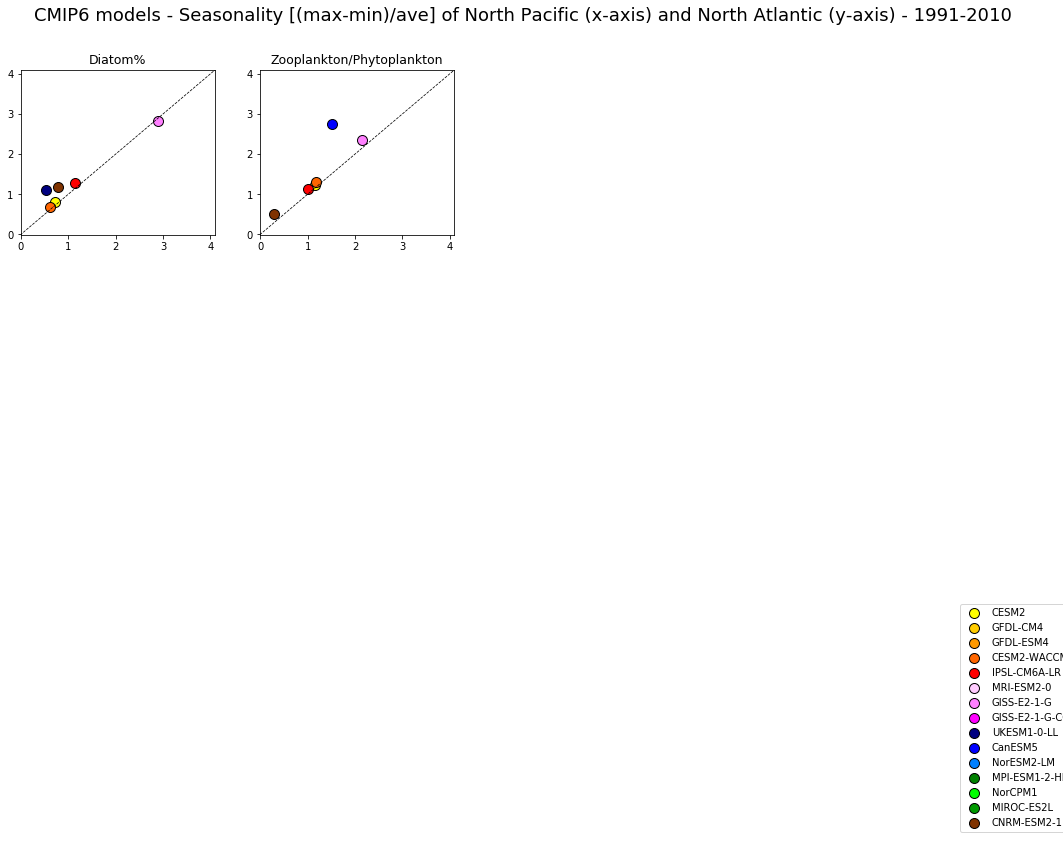

In [96]:
%%time

var2 = ['dfrac', 'zpr']
v2ranges = [[-0.01,4.1],[-0.01,4.1]]
v2titles = ['Diatom%', 'Zooplankton/Phytoplankton']

fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var2:
    i = i + 1
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)

                if np.shape(np_value)[0] > 0:
                    np_plot = (np.nanmax(np_value) - np.nanmin(np_value)) / np.nanmean(np_value)
                    na_plot = (np.nanmax(na_value) - np.nanmin(na_value)) / np.nanmean(na_value)
                    
                    h = plt.scatter(np_plot, na_plot, s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
                else:
                    h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    plt.ylim(v2ranges[i-1])
    plt.xlim(v2ranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-3,1000))
    plt.title(v2titles[i-1], fontsize=12.5, y=1)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.25, wspace=0.23) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Seasonality [(max-min)/ave] of North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NA_NP_max-min_ave_diaf_zoor.png', dpi=600)    


CPU times: user 4.82 s, sys: 573 ms, total: 5.39 s
Wall time: 4.92 s


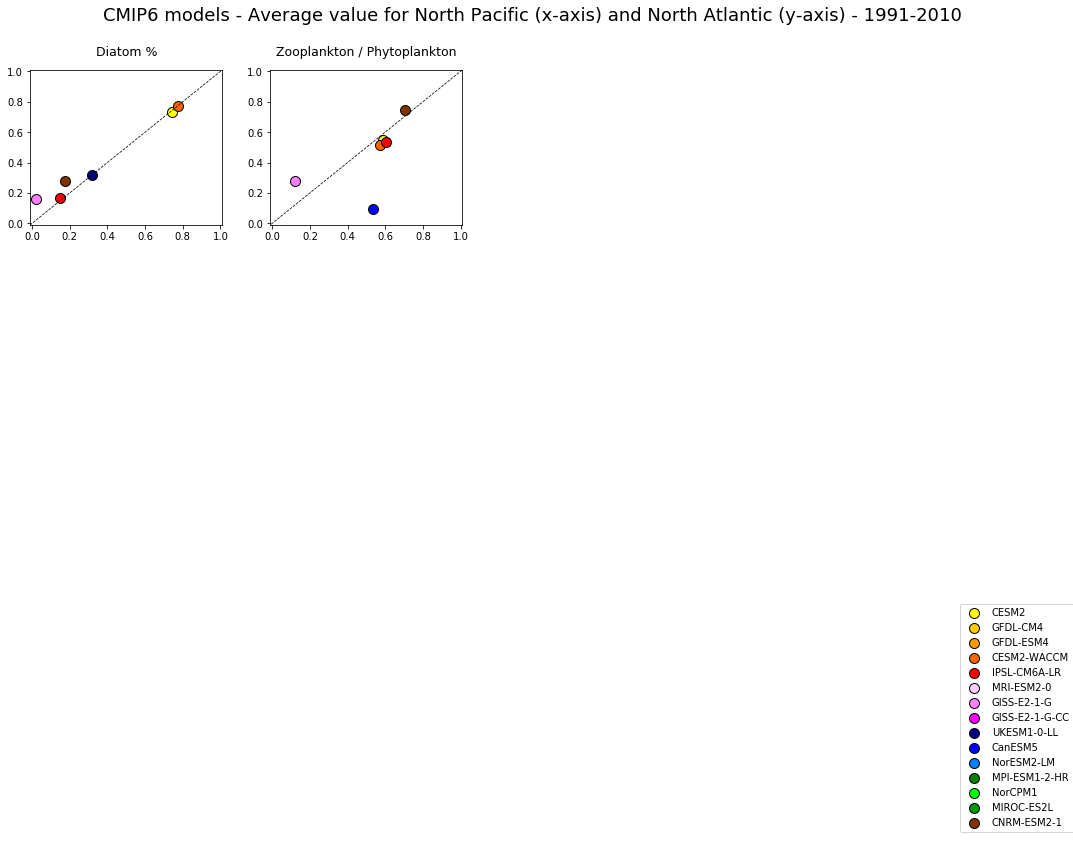

In [97]:
%%time

var2 = ['dfrac', 'zpr']
v2ranges = [[-0.01,1.01],[-0.01,1.01]]
v2titles = ['Diatom %', 'Zooplankton / Phytoplankton']



fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var2:
    i = i + 1
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)
                
                h = plt.scatter(np.mean(np_value), np.mean(na_value), s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    
    plt.ylim(v2ranges[i-1])
    plt.xlim(v2ranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,1000))
    plt.title(v2titles[i-1], fontsize=12.5, y=1.05)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.35, wspace=0.25) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Average value for North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NA_NP_average_diaf_zoor.png', dpi=600)    


In [107]:
np.shape([])[0] > 0

False

In [16]:
not isinstance(staray, xr.Dataset)

False

In [31]:
x=np.asarray(range(len(a)))

In [32]:
m_slope, b_intercept, r_val, p_val, std_err = stats.linregress(x, a)

In [60]:
daa = m_slope*x + b_intercept
da=a-daa+maa

In [35]:
da[:11]

array([3.13734161e-07, 3.23439351e-07, 3.61396544e-07, 4.30233250e-07,
       4.51820699e-07, 2.66981692e-07, 9.72617119e-08, 5.64271145e-08,
       4.42761010e-08, 6.94106409e-08, 1.91273229e-07])

In [36]:
papa_detrended[:11,0,0]

<xarray.DataArray 'chl' (time: 11)>
array([ 5.12630470e-08,  6.09682360e-08,  9.89254295e-08,  1.67762136e-07,
        1.89349585e-07,  4.51057749e-09, -1.65209402e-07, -2.06044000e-07,
       -2.18195013e-07, -1.93060473e-07, -7.11978851e-08])
Coordinates:
    lev      float64 0.5058
  * time     (time) object 1991-01-16 00:00:00 ... 1991-11-16 00:00:00
    lon      float64 220.0
    lat      float64 45.0

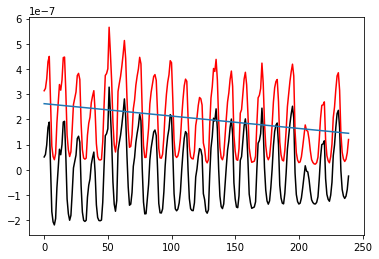

In [62]:
#plt.plot(x,da,'b')
plt.plot(x,papa_detrended[:,0,0],'black')
plt.plot(x,a,'r')
plt.plot(x, daa)

In [31]:
PAPA_plot = []
for model in models:
    ds = papa_dic[model]
    try:
        ds = ds.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1)
        #print(ds)

    except Exception as e:
        print(model, e)
    PAPA_plot.append(ds)
PAPA_plot_dic = {key:value for key, value in zip(models, PAPA_plot)}

GFDL-ESM4 'list' object has no attribute 'groupby'
MPI-ESM1-2-HR 'list' object has no attribute 'groupby'
MRI-ESM2-0 'list' object has no attribute 'groupby'
NorCPM1 'list' object has no attribute 'groupby'
NorESM2-LM 'list' object has no attribute 'groupby'


In [ ]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0))})

for var in var_names:
    xrays = []
    n = 0
    for model in models:
        xray = get_data(df, var, model, expe, freq)
        if isinstance(xray, xr.Dataset):
            n=n+1
        xrays.append(xray)
    if n > 0:
        xray_dic = {key:value for key, value in zip(models, xrays)}
        
        regrids = []
        for model in models:
            if isinstance(xray_dic[model], xr.Dataset):
                ds = xray_dic[model].sel(time=slice(start_year, end_year))[var]  
                if 'latitude' in ds.coords:
                    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
                if 'nav_lat' in ds.coords:
                    ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
                
                dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
                dsr._grid_in = None
                dsr._grid_out = None
                dsr_out0 = dsr(ds)
                dsr_out = xr.Dataset({var:dsr_out0})
                dsr.clean_weight_file()        
            else:
                dsr_out = []      
            regrids.append(dsr_out)   
        regrid_dic = {key:value for key, value in zip(models, regrids)}
        
        papa_aray = []
        for model in models:
            ds = regrid_dic[model]
            
            if isinstance(ds, xr.Dataset):
                if 'lev_partial' in ds.coords:
                    ds = ds.isel(lev_partial=0)
                if 'olevel' in ds.coords:
                    ds = ds.isel(olevel=0)
                if 'lev' in ds.coords:
                    ds = ds.isel(lev=0)     
                
                if ds[var].shape[0]==240:
                    ds_r = ds.sel(lat=slice(45,50)).sel(lon=slice(220,230))
                    dsm = ds_r[var].mean(dim='time')
                    ds_anom = ds_r[var] - dsm
                    ds_anom.load()
                    ds_anom_detrended = xr.apply_ufunc(detrend, ds_anom, kwargs={'axis': 0}).where(~ds_anom.isnull())
                    ds_detrend = ds_anom_detrended + dsm
                    ds = ds_detrend.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                else:
                    ds = []
                    #print(model, regrid_dic[model])       
            papa_aray.append(ds)
        papa_dic = {key:value for key, value in zip(models, papa_aray)}
        
        save_var_file = var + '_papa.txt'
        with open(save_var_file, 'w') as sf:
            for aray in papa_aray:
                sf.write(str(aray))
                
        plt.figure(figsize=(8.5, 5))
        l = []
        for model in models:  
            if isinstance(papa_dic[model], list):
                continue
            else:
                s = papa_dic[model]
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        s = papa_dic[model] * 0.001        # need more infromation
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        s = -papa_dic[model]               # need more infromation
                    if var == 'fgco2':
                        s = papa_dic[model]*(10**(-10))    # need more infromation       
                plt.plot(np.arange(1, 13), s, label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
                l.append(str(model))
        plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
        plt.xticks(np.arange(1, 13), Time_months)
        plt.legend(l,loc='center left', bbox_to_anchor=(1, 0.5))
        savename = var + '_papa.png'
        plt.savefig(savename, dpi=600)   
        plt.close() 

In [25]:
client.close()
cluster.close()

distributed.scheduler - INFO - Remove client Client-7944a2e6-48fe-11ea-8175-debe850967d9
distributed.scheduler - INFO - Remove client Client-7944a2e6-48fe-11ea-8175-debe850967d9
distributed.scheduler - INFO - Close client connection: Client-7944a2e6-48fe-11ea-8175-debe850967d9
Task exception was never retrieved
future: <Task finished coro=<Pod.close() done, defined at /srv/conda/envs/notebook/lib/python3.7/site-packages/dask_kubernetes/core.py:76> exception=ApiException()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/dask_kubernetes/core.py", line 79, in close
    self._pod.metadata.name, self.namespace
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/kubernetes_asyncio/client/api_client.py", line 166, in __call_api
    _request_timeout=_request_timeout)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/kubernetes_asyncio/client/rest.py", line 219, in DELETE
    body=body))
  File "/srv/conda/envs/notebook/lib/py